# This notebook studies how the speed of the moving source influences seeking performance.

In [77]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import animation, rc

import pickle as pkl
import networkx as nx
from matplotlib import style
from functools import partial

import sys
sys.path.append('../')

from utils.dLdp import analytic_dLdp,analytic_dhdz,analytic_dhdq,analytic_FIM
from utils.CentralizedEKF import CentralizedEKF
from CircleGenerator import CircleGenerator
from utils.ConsensusEKF import ConsensusEKF


from labellines import labelLine, labelLines

import time

SEED = 127547

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def single_meas_func(C1,C0,k,b,dist):
    return k*(dist-C1)**b+C0

def joint_meas_func(C1s,C0s,ks,bs,x,ps):

    # Casting for the compatibility of jax.numpy

    C1=np.array(C1s)
    C0=np.array(C0s)
    k=np.array(ks)
    b=np.array(bs)
    p=np.array(ps)

    # Keep in mind that x is a vector of [q,q'], thus only the first half of components are observable.    
    dists=np.linalg.norm(x[:len(x)//2]-p,axis=1)

    return single_meas_func(C1,C0,k,b,dists) 

# Centralized Experiment

In [3]:
def main(N_trails,N_sen,N_iter,source_vel):
    '''
        source_ang_vel: the angular velcity of the source circular motion, measured in degree/step.
    '''
    
    '''Experiment Parameters'''
  
    C_gain=0.1

    # Set up virtual sensors
    C1=-0.3 # Setting C1 as a negative number mitigates the blowing-up effect when the sensors are close to the source.
    C0=0
    k=1
    b=-2
    noise_std = 0.01
    minimum_sensing_reading=1e-5

    # The step size of each sensor
    max_linear_speed=0.1

    # Prepare the motion update for the source
    origin = np.array([0,0])
    radius = 6.0
    theta_0 = 3*np.pi/2
    dtheta = source_vel/(radius)

    source = CircleGenerator(origin,radius,dtheta)

    data={'p':[],'qhat':[],'q':[]}
    t = time.time()
    for _ in range(N_trails):

        '''Initialize Key Data Structures'''
        p_0 = (np.random.rand(N_sen,2)-0.5)*3
        p = np.array(p_0) # Sensor Positions
        
        qhat_0 = np.array([3,4])
        qhat = np.array(qhat_0) # Initial source location estimates
        
        q_0 = np.array([6,0])
        q = q_0 # Actual source location

        # The Centralized EKF
        estimator = CentralizedEKF(qhat_0)

        C1s=C1*np.ones(N_sen)
        C0s = C0*np.ones(N_sen)
        ks = k * np.ones(N_sen)
        bs = b*np.ones(N_sen)

        h=partial(joint_meas_func,C1s,C0s,ks,bs)# Freeze the coefficients, the signature becomes h(z,ps))
        dhdz=partial(analytic_dhdz,C1s=C1s,C0s=C0s,ks=ks,bs=bs)
        dhdqs=partial(analytic_dhdq,C1s=C1s,C0s=C0s,ks=ks,bs=bs)

        '''Main Loop'''

        p_history = []
        qhat_history = []
        q_history = []
        for _ in range(N_iter):
            # Measure
            r = np.linalg.norm(q-p,axis=1)
            y = k* ((r-C1)**b)+C0 + np.random.randn(N_sen)*noise_std
            y[y<=0]=minimum_sensing_reading # We don't want y to be zero or negative.

            # Estimate

            qhat=estimator.update_and_estimate_loc(h,dhdz,y,p)

            # Gradient update

            dp=analytic_dLdp(qhat,p,C1,C0,k,b)
            p-=max_linear_speed*(dp.T/np.linalg.norm(dp,axis=1)).T

            # Record data
            p_history.append(np.array(p))
            qhat_history.append(np.array(qhat)) 
            q_history.append(np.array(q))
            
            # The source moves
            q = source.next_waypoint(q)

            
        data['p'].append(np.array(p_history))
        data['qhat'].append(np.array(qhat_history))
        data['q'].append(q_history)

    print('Time:',time.time()-t)
    return data

In [130]:
vels = [0.5,0.2,0.1,0.05,0.075]
N_trails = 100
N_iter=150
n_sen=6
data={}


np.random.seed(SEED)

for vel in vels:
    data[vel] = main(N_trails,n_sen,N_iter,vel)

Time: 1.928981065750122
Time: 1.8984909057617188
Time: 2.13211989402771
Time: 1.9179840087890625
Time: 2.018604040145874


In [131]:
filepath = "../Data/VelocityTest_Centralized.pkl"
with open(filepath,'wb') as file:
    pkl.dump(data,file)


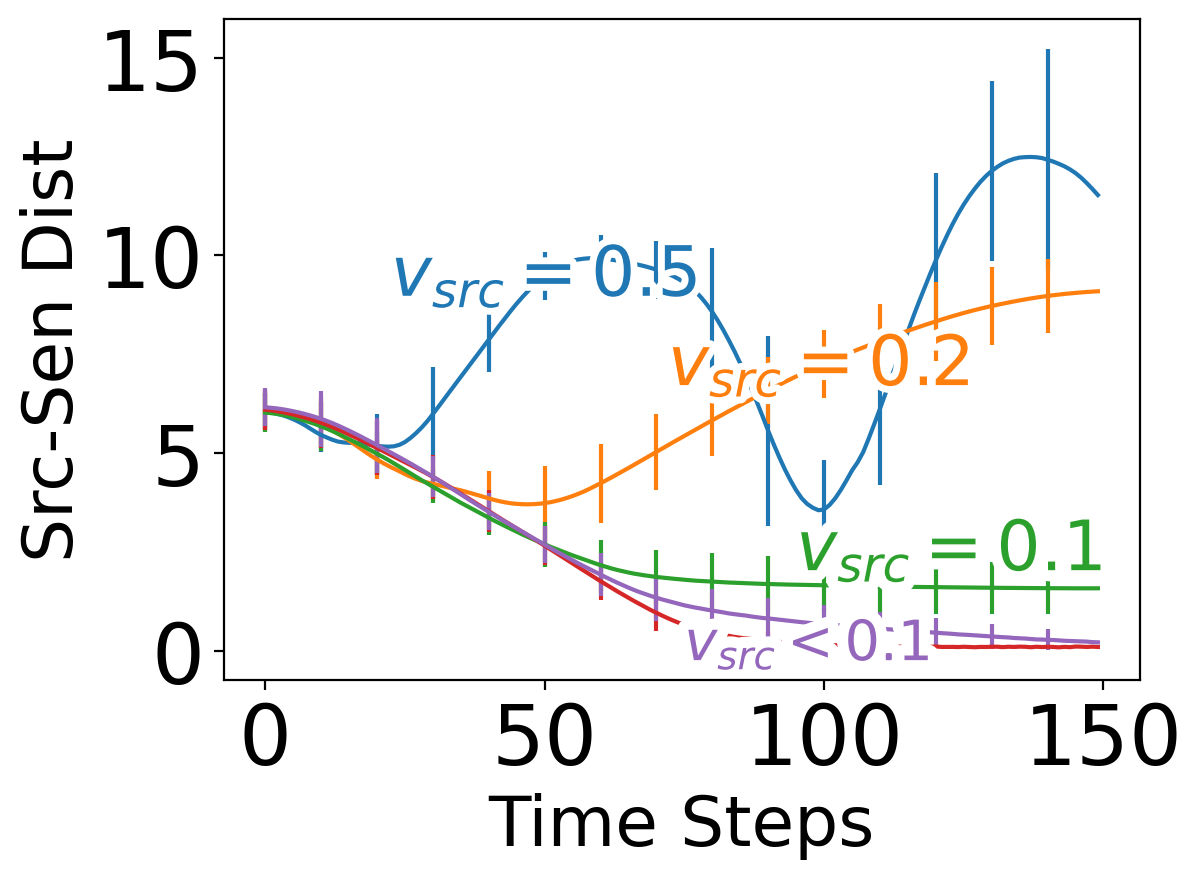

In [172]:
'''Plotting'''

with open(filepath,'rb') as file:
    data=pkl.load(file)
    
plt.figure(dpi=200)
for name,d in data.items():
    ps = np.array(d['p'])
    qhat = np.array(d['qhat'])
    q = np.array(d['q'])
     # qhat.shape=ps.shape=(N_trails,N_iter,space_dim)
    dist = np.linalg.norm(ps-q[:,:,np.newaxis,:],axis=-1)
    # dist.shape = (N_trails,N_iter,N_sen)
    # print(qhat.shape,dist.shape)
 
    
    ave_median_dist = np.mean(np.median(dist,axis=-1),axis=0)
    std_median_dist = np.std(np.median(dist,axis=-1),axis=0)
    N_iter=len(ave_median_dist)

    x = np.arange(N_iter)
  
    plt.errorbar(x,ave_median_dist,yerr=std_median_dist,label= r"$v_{src}=$"+"${:.1f}$".format(name),errorevery=10)

lines = plt.gca().get_lines()

# labelLines(lines[1:], yoffsets=0.01, align=True, backgroundcolor="none")

labelLines(plt.gca().get_lines()[:2], zorder=2.5,align=False,fontsize=25)    


l2 = lines[-3]
labelLine(
    l2,
    95,
    label=r'$v_{src}=0.1$',
    ha="left",
    va="bottom",
    align=False,
    backgroundcolor="none",
    yoffset = -0.0,
    fontsize = 25
)

l1 = lines[-1]
labelLine(
    l1,
    75,
    label=r'$v_{src}<0.1$',
    ha="left",
    va="bottom",
    align=False,
    backgroundcolor="none",
    yoffset = -1.7,
    fontsize = 20
)
    
plt.ylabel('Src-Sen Dist',fontsize=25)
plt.xlabel('Time Steps',fontsize=25)
    # plt.legend(ncol =1 ,fontsize=15)
plt.xticks(fontsize = 30)
plt.yticks(fontsize = 30)

plt.tight_layout()
plt.savefig('../Figures/Velocity_Centralized.png')
plt.show()

# Distributed Experiment

In [7]:
def circulant(n,prev,post,undirected=False):
    """
        Generate a circulant graph with n nodes, node i connected with [i-prev:i+post],i-prev and i+post included but self-loop eliminated.
    """
    G = nx.DiGraph()
    edges = [(j%n,i) for i in range(n) for j in range(i-prev,i+post+1)]
    G.add_edges_from(edges)
    G.remove_edges_from(nx.selfloop_edges(G))
    if undirected:
        G = G.to_undirected()
    return G
    

In [29]:
def distributed_main(N_trails,N_sen,N_iter,source_vel,consensus_est=True,coordinate=True,version='v1',FIM_cons_iter=10):
    '''Experiment Parameters'''
    N_sen = 6

    comm_network_generator=lambda n:circulant(n,prev=1,post=0,undirected=True)

    # The communication network and consensus weight matrix.
    G = comm_network_generator(N_sen)
    A = np.array(nx.adjacency_matrix(G).todense().astype(float))
    A +=np.eye(len(A))
    W = A/np.sum(A,axis=1) # The weight matrix required by parallel two-pass algorithm.

    # The step size of each sensor
    max_linear_speed=0.1
    
    # Prepare the motion update for the source
    origin = np.array([0,0])
    radius = 6.0
    theta_0 = 3*np.pi/2
    dtheta = source_vel/(radius)
    source = CircleGenerator(origin,radius,dtheta)
    
    # Set up virtual sensors
    C1=-0.3 # Setting C1 as a negative number mitigates the blowing-up effect when the sensors are close to the source.
    C0=0
    k=1
    b=-2
    noise_std = 0.01
    minimum_sensing_reading=1e-5
    
    # Consensus Gain
    C_gain = 0.1


    t=time.time()
    data={'p':[],'qhat':[],'q':[]}
    for _ in range(N_trails):

        '''Initialize Key Data Structures'''
        p_0 = np.random.rand(N_sen,2)-0.5
        qhat_0 = np.ones((N_sen,1)).dot(np.array([3,4]).reshape(1,-1))

        p = np.array(p_0) # Sensor Positions
        qhat = np.array(qhat_0)
        
        q_0 = np.array([6,0])
        q = q_0 # Actual source location

        def F_single(dh,qhat,ps):
            A = dh(qhat,ps)
            return A.T.dot(A)

        def joint_F_single(qhat,ps): # Verified to be correct.
            # The vectorized version of F_single.
            # The output shape is (N_sensor, q_dim, q_dim).
            # Where output[i]=F_single(dh,qhat,ps[i])
            A = analytic_dhdq(qhat,ps,C1s=C1,C0s=C0,ks=k,bs=b)
            return A[:,np.newaxis,:]*A[:,:,np.newaxis]


        # The list of single-term partial FIM's.
        F_0 = joint_F_single(qhat,p)
        F = np.array(F_0)

        # The list local estimate of global FIM.
        if version=='v1':
            F_est = F+1e-8*np.eye(2) # Adding a small I to ensure invertibility
        elif version=='v3':
            local_FIM = np.zeros(F.shape)
            for i in G.nodes():
                N_i = [i]+list(G[i]) 
                local_FIM[i,:,:]=analytic_FIM(qhat[N_i,:],p[N_i],C1,C0,k,b)
            F_est = local_FIM # v3: initialize F_est to be local FIMs.

        # The Consensus EKFs
        estimators = [ConsensusEKF(q_0,C_gain=C_gain) for q_0 in qhat_0]

        # The initialization of local measurement functions and the derivative functions. 
        # This is not very pretty. But is required by Consensus EKF.
        hs = []
        dhdzs = []
        dhdqs = []
        C1s=C1*np.ones(N_sen)
        C0s = C0*np.ones(N_sen)
        ks = k * np.ones(N_sen)
        bs = b*np.ones(N_sen)

        d = np.zeros(N_sen)
        for i in G.nodes():  
            N_i = [i]+list(G[i])     
            C1s_i=C1s[N_i]
            C0s_i = C0s[N_i]
            ks_i = ks[N_i]
            bs_i = bs[N_i]
            hs.append(partial(joint_meas_func,C1s_i,C0s_i,ks_i,bs_i))# Freeze the coefficients, the signature becomes h(z,ps))
            dhdzs.append(partial(analytic_dhdz,C1s=C1s_i,C0s=C0s_i,ks=ks_i,bs=bs_i))
            dhdqs.append(partial(analytic_dhdq,C1s=C1s_i,C0s=C0s_i,ks=ks_i,bs=bs_i))
            d[i]=len(N_i)

        # Variables for parallel two-pass algorithm.
        inv_d = 1/d
        w_F_est = F_est*inv_d[:,np.newaxis,np.newaxis]

        '''Main Loop'''

        p_history = []
        qhat_history = []
        q_history = []
        for _ in range(N_iter):
            # Measure
            r = np.linalg.norm(q-p,axis=1)
            y = k* ((r-C1)**b)+C0 + np.random.randn(N_sen)*noise_std
            y[y<=0]=minimum_sensing_reading # We don't want y to be zero or negative.


            # Estimate
            zhats = np.array([est.z for est in estimators])
            new_qhat = np.zeros(qhat.shape)
            local_FIM = np.zeros(F_est.shape)
            for i in G.nodes():
                N_i = [i]+list(G[i]) 
                # Estimate
                if consensus_est:
                    inv_d_neighbor=inv_d[N_i]
                else:
                    inv_d_neighbor=None
                new_qhat[i,:]=estimators[i].update_and_estimate_loc(hs[i],dhdzs[i],y[N_i],p[N_i],zhats[N_i])
                if not coordinate:
                    local_FIM[i,:,:]=analytic_FIM(qhat[N_i,:],p[N_i],C1,C0,k,b)

            qhat=new_qhat

            # Partial FIM Calculation and FIM consensus
            for _ in range(FIM_cons_iter):
                new_F = joint_F_single(qhat,p)
                dF = new_F-F
                F=new_F

                # FIM Consensus using parallel two-pass algorithm
                inv_d = W.dot(inv_d)
                w_F_est = (w_F_est.T.dot(W)).T + dF*inv_d[:,np.newaxis,np.newaxis]
                F_est = w_F_est/inv_d[:,np.newaxis,np.newaxis]   

            # Gradient update
            FIM_cand= F_est if coordinate else local_FIM
            for i in range(N_sen):
                dp=analytic_dLdp(qhat[i:i+1],p[i:i+1],C1,C0,k,b,FIM=FIM_cand[i])

                p[i:i+1]-=max_linear_speed*dp/np.linalg.norm(dp)

            # The source moves
            q = source.next_waypoint(q)

            # Record data
            p_history.append(np.array(p))
            qhat_history.append(np.array(qhat))
            q_history.append(np.array(q))

        data['p'].append(np.array(p_history))
        data['qhat'].append(np.array(qhat_history))
        data['q'].append(np.array(q_history))

    print('Time:',time.time()-t)
    return data

In [102]:
vels = [0.5,0.2,0.1,0.05,0.075]
N_trails = 100
N_iter=150
n_sen=6
data={}


np.random.seed(SEED)

for vel in vels:
    data[vel] = distributed_main(N_trails,n_sen,N_iter,vel)

/var/folders/4v/bq7m33xj6b9fm2jfm0ngdg3c0000gn/T/ipykernel_18363/1021940024.py:9: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = np.array(nx.adjacency_matrix(G).todense().astype(float))


Time: 10.582544326782227
Time: 10.466251134872437
Time: 10.464539051055908
Time: 10.451647996902466
Time: 10.477870225906372


In [103]:
filepath = "../Data/VelocityTest_Distributed.pkl"
with open(filepath,'wb') as file:
    pkl.dump(data,file)


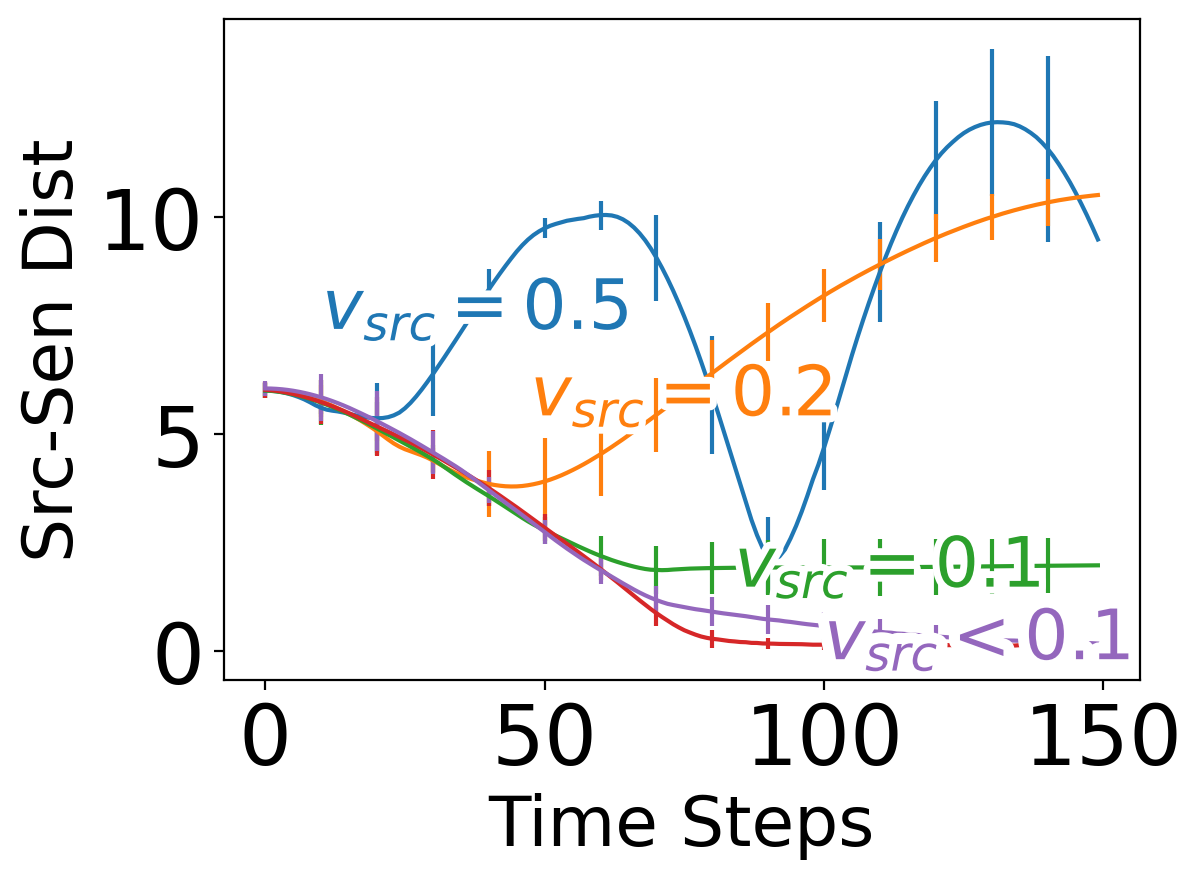

In [174]:
'''Plotting'''

filepath = "../Data/VelocityTest_Distributed.pkl"

with open(filepath,'rb') as file:
    data=pkl.load(file)
    
plt.figure(dpi=200)
for name,d in data.items():
    ps = np.array(d['p'])
    qhat = np.array(d['qhat'])
    q = np.array(d['q'])
     # qhat.shape=ps.shape=(N_trails,N_iter,space_dim)
    dist = np.linalg.norm(ps-q[:,:,np.newaxis,:],axis=-1)
    # dist.shape = (N_trails,N_iter,N_sen)
    # print(qhat.shape,dist.shape)
 
    
    ave_median_dist = np.mean(np.median(dist,axis=-1),axis=0)
    std_median_dist = np.std(np.median(dist,axis=-1),axis=0)
    N_iter=len(ave_median_dist)

    x = np.arange(N_iter)
  
    plt.errorbar(x,ave_median_dist,yerr=std_median_dist,label= r"$v_{src}=$"+"${:.1f}$".format(name),errorevery=10)

lines = plt.gca().get_lines()

# labelLines(lines[1:], yoffsets=0.01, align=True, backgroundcolor="none")

labelLines(plt.gca().get_lines()[:3], zorder=2.5,align=False,fontsize=25)    

l1 = lines[-1]
labelLine(
    l1,
    100,
    label=r'$v_{src}<0.1$',
    ha="left",
    va="bottom",
    align=False,
    backgroundcolor="none",
    yoffset = -1.1,
    fontsize = 25
)
    
plt.ylabel('Src-Sen Dist',fontsize=25)
plt.xlabel('Time Steps',fontsize=25)
    # plt.legend(ncol =1 ,fontsize=15)
plt.xticks(fontsize = 30)
plt.yticks(fontsize = 30)

plt.tight_layout()
plt.savefig('../Figures/Velocity_Distributed.png')
plt.show()